# Applied ML CSC 4505 Final Project 

### Yasmin Lorin Kaygalak & Natalie Bohmbach



In [1]:
!pip install seaborn
!python -m spacy download en_core_web_sm
!pip install gensim



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 29.8 MB/s eta 0:00:00a 0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [2]:
# Importing necessary libraries
import pandas as pd
import nltk
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix
)
from gensim.models import Word2Vec
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression as W2VLogistic

# Downloading necessary data
nltk.download('punkt')
nltk.download('stopwords')
nlp = spacy.load("en_core_web_sm")
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/lorin.kaygalak/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/lorin.kaygalak/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/lorin.kaygalak/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
# CONFIG
# Change this to False if you want to keep stopwords
REMOVE_STOPWORDS = True

In [4]:
# STEP 1
# Reading fake news dataset into a pandas dataframe
fake_df = pd.read_csv('datasets/Fake.csv')
fake_df.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [5]:
# STEP 1
# Reading true news dataset into a pandas dataframe
true_df = pd.read_csv('datasets/True.csv')
true_df.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [6]:
# STEP 2
# Adding labels 
fake_df['label'] = 0  # Fake news
true_df['label'] = 1  # Real news

In [7]:
# STEP 3
# Checking the info for null values - neither dataset has any
fake_df.info()
true_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23481 entries, 0 to 23480
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    23481 non-null  object
 1   text     23481 non-null  object
 2   subject  23481 non-null  object
 3   date     23481 non-null  object
 4   label    23481 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 917.4+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21417 entries, 0 to 21416
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    21417 non-null  object
 1   text     21417 non-null  object
 2   subject  21417 non-null  object
 3   date     21417 non-null  object
 4   label    21417 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 836.7+ KB


In [8]:
# STEP 4
# Combining datasets for unified training
df = pd.concat([fake_df, true_df], ignore_index=True)

In [9]:
# STEP 5
# Combine title and text
df['combined'] = df['title'].astype(str) + " " + df['text'].astype(str)

# Lowercase, remove punctuation, tokenize, remove stopwords
def text_cleaner(text, remove_stopwords=True):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)  # Keep only letters and spaces
    tokens = text.split()
    if remove_stopwords:
        tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

In [18]:
# STEP 6
# Applying text cleaner and joining tokens back into string for TF-IDF
df['text_tokens'] = df['combined'].apply(lambda x: text_cleaner(x, remove_stopwords=True))
df['text_clean'] = df['combined'].apply(lambda x: text_cleaner(x, remove_stopwords=True))

In [11]:
# STEP 7
# Train and Test data split 
X = df['text_clean']
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
# STEP 8
# TF-IDF Vectorization 
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [13]:
# STEP 9 Defining Models 
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Naive Bayes": MultinomialNB(),
    "SVM (Linear Kernel)": LinearSVC(),
    "MLP Classifier": MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, random_state=42)
}


Logistic Regression
Accuracy: 0.9891982182628062
Precision: 0.9870892018779343
Recall: 0.9901106663527196
F1 Score: 0.9885976254848948

Classification Report:
              precision    recall  f1-score   support

        Fake       0.99      0.99      0.99      4733
        Real       0.99      0.99      0.99      4247

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980



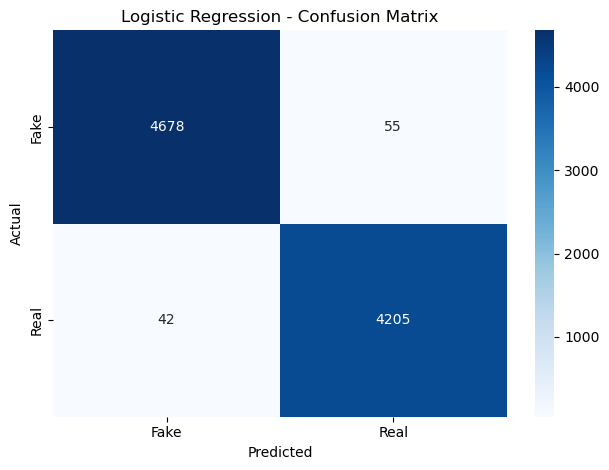


Naive Bayes
Accuracy: 0.9332962138084633
Precision: 0.9351145038167938
Recall: 0.9230044737461738
F1 Score: 0.9290200260694395

Classification Report:
              precision    recall  f1-score   support

        Fake       0.93      0.94      0.94      4733
        Real       0.94      0.92      0.93      4247

    accuracy                           0.93      8980
   macro avg       0.93      0.93      0.93      8980
weighted avg       0.93      0.93      0.93      8980



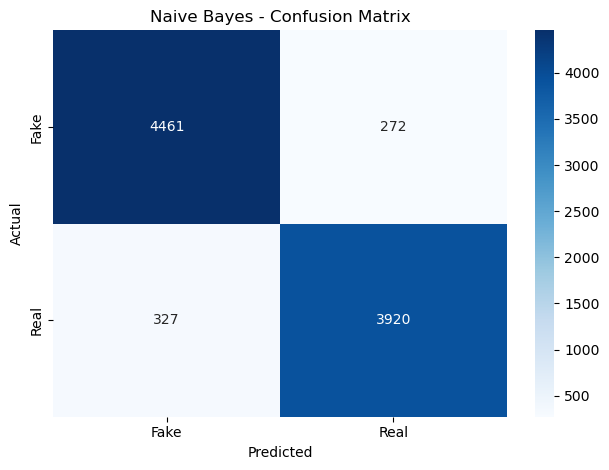


SVM (Linear Kernel)
Accuracy: 0.9951002227171493
Precision: 0.9945869616380325
Recall: 0.9950553331763597
F1 Score: 0.9948210922787194

Classification Report:
              precision    recall  f1-score   support

        Fake       1.00      1.00      1.00      4733
        Real       0.99      1.00      0.99      4247

    accuracy                           1.00      8980
   macro avg       1.00      1.00      1.00      8980
weighted avg       1.00      1.00      1.00      8980



/Users/lorin.kaygalak/miniconda3/envs/homl3/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


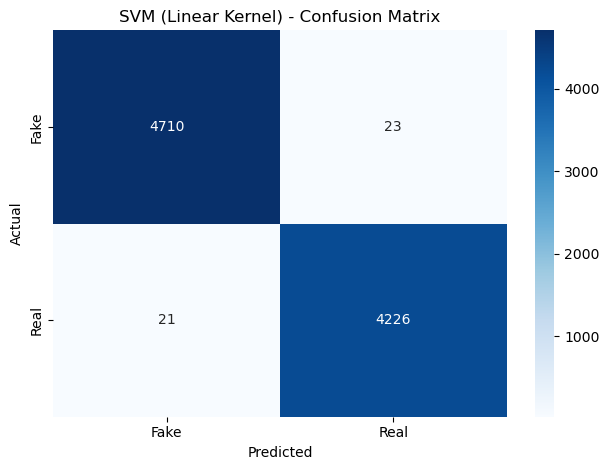


MLP Classifier
Accuracy: 0.9914253897550112
Precision: 0.9931409649952696
Recall: 0.9886979044031081
F1 Score: 0.9909144542772862

Classification Report:
              precision    recall  f1-score   support

        Fake       0.99      0.99      0.99      4733
        Real       0.99      0.99      0.99      4247

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980



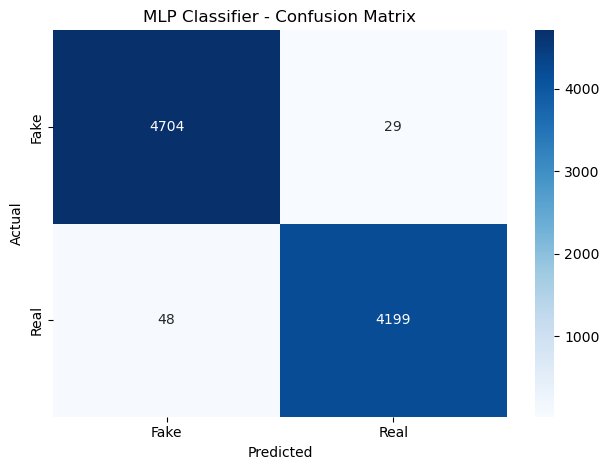


Random Forest
Accuracy: 0.9979955456570155
Precision: 0.9971784622619327
Recall: 0.9985872380503885
F1 Score: 0.9978823529411764

Classification Report:
              precision    recall  f1-score   support

        Fake       1.00      1.00      1.00      4733
        Real       1.00      1.00      1.00      4247

    accuracy                           1.00      8980
   macro avg       1.00      1.00      1.00      8980
weighted avg       1.00      1.00      1.00      8980



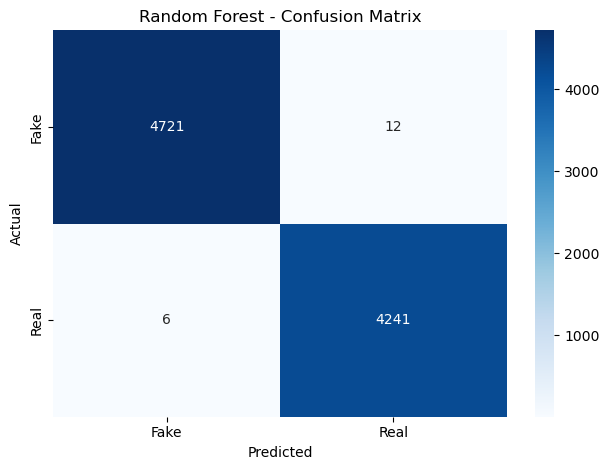


Gradient Boosting
Accuracy: 0.9964365256124722
Precision: 0.9941383352872216
Recall: 0.9983517777254532
F1 Score: 0.9962406015037594

Classification Report:
              precision    recall  f1-score   support

        Fake       1.00      0.99      1.00      4733
        Real       0.99      1.00      1.00      4247

    accuracy                           1.00      8980
   macro avg       1.00      1.00      1.00      8980
weighted avg       1.00      1.00      1.00      8980



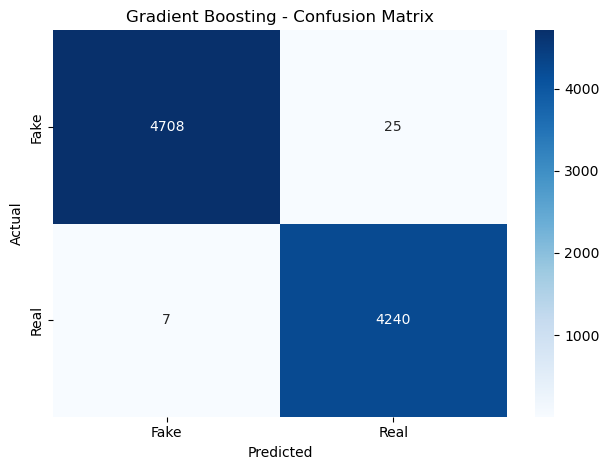

In [14]:
# STEP 10
# Train, Predict, and Evaluate 
# for name, model in models.items():
#     print(f"\n{name}")
#     model.fit(X_train_tfidf, y_train)
#     y_pred = model.predict(X_test_tfidf)

#     print("Accuracy:", accuracy_score(y_test, y_pred))
#     print("Precision:", precision_score(y_test, y_pred))
#     print("Recall:", recall_score(y_test, y_pred))
#     print("F1 Score:", f1_score(y_test, y_pred))
#     print("\nClassification Report:")
#     print(classification_report(y_test, y_pred, target_names=["Fake", "Real"]))

#     cm = confusion_matrix(y_test, y_pred)
#     sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Fake", "Real"], yticklabels=["Fake", "Real"])
#     plt.title(f"{name} - Confusion Matrix")
#     plt.xlabel("Predicted")
#     plt.ylabel("Actual")
#     plt.tight_layout()
#     plt.show()

results = []

for name, model in models.items():
    print(f"\n{name}")
    model.fit(X_train_tfidf, y_train)
    y_pred = model.predict(X_test_tfidf)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    results.append({
        "Model": name,
        "Accuracy": round(acc, 4),
        "Precision": round(prec, 4),
        "Recall": round(rec, 4),
        "F1 Score": round(f1, 4)
    })

    print("Accuracy:", acc)
    print("Precision:", prec)
    print("Recall:", rec)
    print("F1 Score:", f1)
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=["Fake", "Real"]))

    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Fake", "Real"], yticklabels=["Fake", "Real"])
    plt.title(f"{name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()



In [15]:
# STEP 11
# Feature Importance for Logistic Regression 
log_model = models["Logistic Regression"]
if hasattr(log_model, "coef_"):
    feature_names = vectorizer.get_feature_names_out()
    coefs = log_model.coef_[0]
    top_pos = np.argsort(coefs)[-20:]
    top_neg = np.argsort(coefs)[:20]

    print("\nTop Features Predicting Real News:")
    for i in top_pos[::-1]:
        print(f"{feature_names[i]}: {coefs[i]:.4f}")

    print("\nTop Features Predicting Fake News:")
    for i in top_neg:
        print(f"{feature_names[i]}: {coefs[i]:.4f}")


Top Features Predicting Real News:
reuters: 25.2112
said: 17.2733
trumps: 8.2183
wednesday: 5.1669
washington: 5.1353
tuesday: 4.5469
thursday: 4.2901
republican: 4.2393
us: 4.2327
friday: 4.0457
nov: 3.6107
monday: 3.6069
reporters: 3.5101
edt: 3.4877
thats: 3.2615
im: 3.2275
minister: 3.2189
presidential: 3.1665
dont: 3.0127
comment: 2.9383

Top Features Predicting Fake News:
video: -9.5499
via: -8.4049
gop: -5.2285
image: -4.9201
america: -4.8255
wire: -4.7352
obama: -4.7279
hillary: -4.6702
even: -4.2876
breaking: -4.2558
mr: -4.1251
like: -4.0032
american: -3.9436
watch: -3.5000
rep: -3.3026
isis: -3.2991
images: -3.2154
read: -3.2093
daily: -3.0383
sen: -3.0279


In [16]:
# STEP 12
# Feature Importance for Random Forest
rf_model = models["Random Forest"]
importances = rf_model.feature_importances_
indices = np.argsort(importances)[-20:]

print("\nTop Features from Random Forest:")
for i in reversed(indices):
    print(f"{feature_names[i]}: {importances[i]:.4f}")



Top Features from Random Forest:
reuters: 0.2440
said: 0.0638
video: 0.0249
via: 0.0239
image: 0.0214
us: 0.0130
watch: 0.0108
washington: 0.0105
wednesday: 0.0100
even: 0.0096
like: 0.0095
images: 0.0087
thursday: 0.0083
tuesday: 0.0080
minister: 0.0076
america: 0.0070
friday: 0.0064
prime: 0.0061
spokesman: 0.0056
know: 0.0054


In [19]:
# STEP 13
# Word2Vec Embedding and Classification
print("\nTraining Word2Vec model...")
w2v_model = Word2Vec(sentences=df['text_tokens'], vector_size=100, window=5, min_count=2, workers=4)

def document_vector(doc):
    doc = [word for word in doc if word in w2v_model.wv.key_to_index]
    if len(doc) == 0:
        return np.zeros(100)
    return np.mean(w2v_model.wv[doc], axis=0)

X_w2v = np.array([document_vector(tokens) for tokens in df['text_tokens']])
X_train_w2v, X_test_w2v, y_train_w2v, y_test_w2v = train_test_split(X_w2v, y, test_size=0.2, random_state=42)

w2v_clf = make_pipeline(StandardScaler(), W2VLogistic(max_iter=1000))
w2v_clf.fit(X_train_w2v, y_train_w2v)
y_pred_w2v = w2v_clf.predict(X_test_w2v)

print("\nWord2Vec + Logistic Regression")
print("Accuracy:", accuracy_score(y_test_w2v, y_pred_w2v))
print("Precision:", precision_score(y_test_w2v, y_pred_w2v))
print("Recall:", recall_score(y_test_w2v, y_pred_w2v))
print("F1 Score:", f1_score(y_test_w2v, y_pred_w2v))



Training Word2Vec model...

Word2Vec + Logistic Regression
Accuracy: 0.7837416481069043
Precision: 0.7714958775029447
Recall: 0.7711325641629385
F1 Score: 0.7713141780499294


In [21]:
# STEP 14 
# Comparison Table
results_df = pd.DataFrame(results)
results_df.loc[len(results_df.index)] = ["Word2Vec + Logistic", 
    round(accuracy_score(y_test_w2v, y_pred_w2v), 4),
    round(precision_score(y_test_w2v, y_pred_w2v), 4),
    round(recall_score(y_test_w2v, y_pred_w2v), 4),
    round(f1_score(y_test_w2v, y_pred_w2v), 4)
]

print("\n Model Comparison Table")
print(results_df.sort_values(by="F1 Score", ascending=False))



 Model Comparison Table
                 Model  Accuracy  Precision  Recall  F1 Score
4        Random Forest    0.9980     0.9972  0.9986    0.9979
5    Gradient Boosting    0.9964     0.9941  0.9984    0.9962
2  SVM (Linear Kernel)    0.9951     0.9946  0.9951    0.9948
3       MLP Classifier    0.9914     0.9931  0.9887    0.9909
0  Logistic Regression    0.9892     0.9871  0.9901    0.9886
1          Naive Bayes    0.9333     0.9351  0.9230    0.9290
6  Word2Vec + Logistic    0.7837     0.7715  0.7711    0.7713


/var/folders/bk/kmcng2pn54s1td0wmyvw0p0c0000gn/T/ipykernel_12342/3332476557.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="F1 Score", y="Model", data=results_df.sort_values(by="F1 Score", ascending=True), palette="viridis")


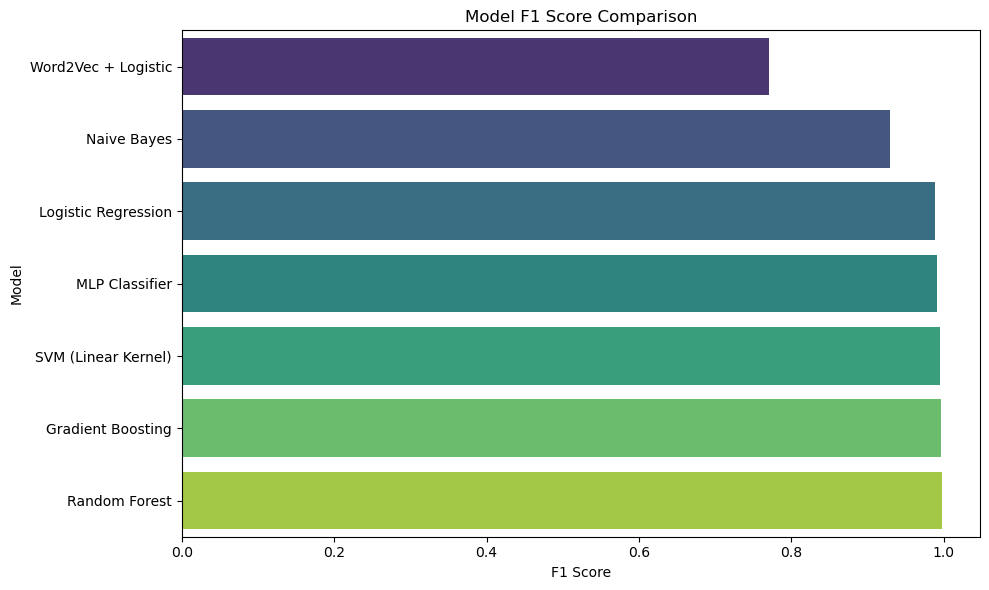

In [22]:
# STEP 15
# F1 Score Bar Plot
plt.figure(figsize=(10, 6))
sns.barplot(x="F1 Score", y="Model", data=results_df.sort_values(by="F1 Score", ascending=True), palette="viridis")
plt.title("Model F1 Score Comparison")
plt.xlabel("F1 Score")
plt.ylabel("Model")
plt.tight_layout()
plt.show()
